In [1]:
%%bash

# Delete output of previous run
rm -rf *.in.* species* *.out* *.inp* *.log*

In [2]:
import mosdef_cassandra as mc
import generate_mc as gen
import mbuild as mb
import foyer
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import random

In [3]:
def gen_system(dims=[2, 2, 2]):
    defaults_dict = {'stoichiometry': {'Mo': 1, 'V': 0.15, 'Nb': 0.13, 'Te': 0.12},
                     'dimensions': dims,
                     'template': 'M1UnitCell_mod.pdb',
                     'crystal_x': 2.148490,
                     'crystal_y': 2.664721,
                     'crystal_z': 0.400321,
                     'z_reactor_size': 20.0,
                     'forcefield': None
                     }

    system = gen.Surface(defaults_dict['dimensions'],
                        defaults_dict['template'],
                         defaults_dict['stoichiometry'],
                         True,
                         defaults_dict['crystal_x'],
                         defaults_dict['crystal_y'],
                         defaults_dict['crystal_z']
                        )
    system.translate_to(np.zeros(3)) # Added so that periodicity doesn't error out
    system.periodicity = system.boundingbox.lengths # necessary
    #system.to_parmed() # Triggers an error
    return system

In [4]:
def apply_ff(system, systemFF, organicFF=None):
    typed_surface = systemFF.apply(system.children[0],
                            assert_angle_params=False,
                            assert_bond_params=False,
                            assert_dihedral_params=False,
                            assert_improper_params=False)
    if organicFF:
        for idx, child in enumerate(system.children):
            if idx == 0:
                pass
            else:
                typed_comp = organicFF.apply(child)
                typed_surface += typed_comp
    return typed_surface

In [5]:
mc.utils.detect_cassandra_binaries();

Using the following executables for Cassandra:
Python: /home/nealeellyson/miniconda3/envs/mc/bin/python
library_setup: /home/nealeellyson/miniconda3/envs/mc/bin/library_setup.py
Cassandra: /home/nealeellyson/miniconda3/envs/mc/bin/cassandra.exe


In [6]:
surface = gen_system(dims=[1, 1, 1])
surface.visualize(show_ports=True, color_scheme={'O':'red',
                                               'Te': 'black',
                                               'V': 'black',
                                               'Nb': 'black',
                                               'Mo': 'black'})

Adding [0, 0, 0] to system... 


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
ethane = mb.load("CC", smiles=True)
ethane.visualize().show()

/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/compound.py:2749: UserWarning: No unitcell detected for pybel.Molecule CC	

  warn("No unitcell detected for pybel.Molecule {}".format(pybel_mol))


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
# Load forcefields
opls_uff = foyer.forcefields.Forcefield(forcefield_files='forcefields/FF_opls_uff_M1.xml')
oplsaa = foyer.forcefields.load_OPLSAA()

# Use foyer to apply forcefields
typed_surface = apply_ff(surface, opls_uff, )
typed_ethane = oplsaa.apply(ethane)

# Create box and species list
box_list = [surface]
species_list = [typed_surface, typed_ethane]

/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/foyer/forcefield.py:433: UserWarning: No force field version number found in force field XML file.
  'No force field version number found in force field XML file.'
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/foyer/forcefield.py:445: UserWarning: No force field name found in force field XML file.
  'No force field name found in force field XML file.'
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/foyer/validator.py:132: ValidationWarning: You have empty smart definition(s)
  warn("You have empty smart definition(s)", ValidationWarning)
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)
/home/nealeellyson/miniconda3/envs/mc/l

In [9]:
print('surface.boundingbox.lengths:', surface.boundingbox.lengths)
print('min(surface.boundingbox.lengths)/2.1:',min(surface.boundingbox.lengths)/2.1)

surface.boundingbox.lengths: [2.0970999  2.65140007 0.44999999]
min(surface.boundingbox.lengths)/2.1: 0.21428570860908144


In [35]:
%%bash

# Delete output of previous run
rm -rf *.in.* species* *.out* *.inp* *.log*

In [10]:
# Since we have an occupied box we need to specify
# the number of each species present in the intial config
mols_in_boxes = [[1,0]]

system = mc.System(box_list, species_list, mols_in_boxes=mols_in_boxes)
moves = mc.Moves("gcmc", species_list)    # Grand Canonical Monte Carlo

custom_args = {
    "chemical_potentials": ["none", -30.0],
    "rcut_min": 0.5,
    "vdw_cutoff": min(surface.boundingbox.lengths)/3, #min(box.lengths)/2.1, # OG: 14.0, 
    "charge_style": "none",
    #"charge_cutoff": 14.0,
    "coord_freq": 100,
    "prop_freq": 10,
}

mc.run(system=system, 
       moves=moves, 
       run_type="equilibration", 
       run_length=10000, 
       temperature=300.0, **custom_args)

Treating <Structure 160 atoms; 1 residues; 0 bonds; PBC (orthogonal); NOT parametrized> as a non-insertable rigid species since it has no bonds
Using the following executables for Cassandra:
Python: /home/nealeellyson/miniconda3/envs/mc/bin/python
library_setup: /home/nealeellyson/miniconda3/envs/mc/bin/library_setup.py
Cassandra: /home/nealeellyson/miniconda3/envs/mc/bin/cassandra.exe
Generating fragment libraries...


/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:178: UserWarning: No bonds found. Cassandra will interpet this as a rigid species
  warnings.warn("No bonds found. Cassandra will interpet "
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:564: UserWarning: More than two atoms present but no fragments identified.
  warnings.warn('More than two atoms present but '
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:303: UserWarning: Warning, type name opls_135 will be shortened to six characters as ls_135. Please confirm your final MCF.
  "MCF.".format(itype,itype[-6:]))
/home/nealeellyson/miniconda3/envs/mc/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:303: UserWarning: Warning, type name opls_140 will be shortened to six characters as ls_140. Please confirm your final MCF.
  "MCF.".format(itype,itype[-6:]))


Running Cassandra...


In [11]:
%%bash

cat *.log

********************************************************************************
                ______                                __                        
               / ____/___ _______________ _____  ____/ /________ _              
              / /   / __ `/ ___/ ___/ __ `/ __ \/ __  / ___/ __ `/              
             / /___/ /_/ (__  |__  ) /_/ / / / / /_/ / /  / /_/ /               
             \____/\__,_/____/____/\__,_/_/ /_/\__,_/_/   \__,_/                
                                                                                
********************************************************************************
**********************************Log File**************************************
********************************************************************************

For any published work that uses Cassandra, cite the following reference:
    Shah JK, Marin‐Rimoldi E, Mullen RG, Keene BP, Khan S,
    Paluch AS, Rai N, Romanielo LL, Rosch TW, Yoo B, Mag

In [14]:
%%bash

# move the output
mkdir output
mv *.in.* species* *.out* *.inp* output

mkdir: cannot create directory ‘output’: File exists
mv: cannot stat ‘*.in.*’: No such file or directory
mv: cannot move ‘species1’ to ‘output/species1’: File exists
mv: cannot move ‘species2’ to ‘output/species2’: File exists
mv: cannot stat ‘*.out*’: No such file or directory
mv: cannot stat ‘*.inp*’: No such file or directory


CalledProcessError: Command 'b'\n# move the output\nmkdir output\nmv *.in.* species* *.out* *.inp* output\n'' returned non-zero exit status 1.

In [15]:
import ex_render_cassandra as erc

In [18]:
xyzfile = "output/gcmc.out.xyz"
boxfile = "output/gcmc.out.H"

traj = erc.make_traj(xyzfile, boxfile)

In [20]:
erc.display_movie(erc.render_sphere_frame, traj)
erc.display_movie(erc.render_sphere_frame, traj, gif="traj.gif")

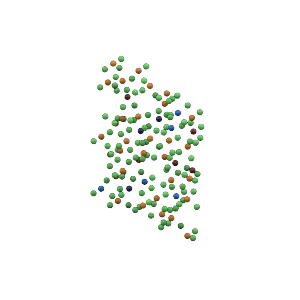

In [30]:
erc.render_sphere_frame(traj[0], color="jet")
erc.render_sphere_frame(traj[1], color="jet")
erc.render_sphere_frame(traj[2], color="jet")
erc.render_sphere_frame(traj[3], color="jet")

# Errors:
`Initial vdw cutoff is greater than half the minimum box length
This error occurred in subroutine Get_Pair_Style on step 0.`

Jenny: 
> Fixed by making the boxlist an empty box with correct size

My fix:
```
"vdw_cutoff": min(surface.boundingbox.lengths)/3,
"charge_style": "none",
#"charge_cutoff": 14.0,
```

Open in VMD in terminal with `vmd [filename]`

ovito
set up x11 forwarding
on fry: ssh -Y -> asks for x11 forwarding